In [2]:
import sys
import numpy as np
import random

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [3]:
'''
Enumerate states for a 3x3 grid ==> 81 states 
(9 choices for pacman location x 9 choices for ghost location)

y    _0_|_1_|_2_
|    _3_|_4_|_5_
v     6 | 7 | 8
    x -->

Each x,y pair represented as an integer number corresponding to the diagram above
'''

states_num = [];

for s in range(81):
    for p in range(9):
        for g in range(9):
            states_num.append( (p, g) )
                    
#for s in range(81):
#    print("state ", s, ": ", states_num[s])

In [4]:
def grid_to_xy(number):
    switch = {
        0: [0,0],
        1: [1,0],
        2: [2,0],
        3: [0,1],
        4: [1,1],
        5: [2,1],
        6: [0,2],
        7: [1,2],
        8: [2,2]
    }
    return switch.get(number, "invalid entry")

def xy_to_grid(x,y):
    switch = {
        0: {0:0, 1:3, 2:6},
        1: {0:1, 1:4, 2:7},
        2: {0:2, 1:5, 2:8}
    }
    x = switch.get(x,"invalid entry")

    if x == "invalid entry":
        return x
    else:
        return x.get(y,"invalid entry")

def return_state(states, p, g):
    return states.index( (p,g) )

def move(x, y, action):
    if action == UP:
        y = max(0, y-1)
    elif action == RIGHT:
        x = min(2, x+1)
    elif action == DOWN:
        y = min(2, y+1)
    elif action == LEFT:
        x = max(0, x-1)
    return xy_to_grid(x, y)

In [5]:
class PacmanEnv:
    '''
    Class to initialize and store information about the Pacman environment for program planning algorithms.

    Properties:
        P[s][a] is a list of is a list of transition tuples (prob, next_state, reward, done)
        num_states = number of states (set to default for 3x3 grid)
        num_actions = number of actions (set to 4)
        pellet_loc = location of pellet (set to 2, i.e. [2,0] by default)

    Methods:
        return_state: Returns state number given location of pacman and the ghost
        move: Moves pacman given current location and action input. Returns grid location number
        calculate_reward: Returns reward for current location of pacman. Used to evaluate R(s,a,s') by 
                        first determining s' through move(s,a), then calculating the reward at s'.
        grid_to_xy: Returns corresponding (x,y) coordinate pair for valid grid location integer input
                    If number out of range, returns 'invalid entry' error message
        xy_to_grid: Returns corresponding grid location # for given (x,y) coordinate pair input
                    If number out of range, returns 'invalid entry' error message
    '''

    def __init__(self, states=states_num, num_states=81, num_actions=4, pellet_loc=2):
        self.states = states
        self.num_states = num_states
        self.num_actions = num_actions
        self.pellet_loc = pellet_loc
        
        P = {s : {a : [] for a in range(num_actions)} for s in range(num_states)}
        
        # parameters must be of the same type, i.e. [x,y] or int value 0-8
        # need to adjust to include reward definition for bumping into walls
        def calculate_reward(pacman_new_loc, ghost_new_loc, ghost_current_loc, pellet_location):
            if pacman_new_loc == ghost_current_loc: # pacman moved to the ghost's location
                return -1000
            elif pacman_new_loc == pellet_location:
                return 1000
            elif pacman_new_loc == ghost_new_loc: # the ghost moved to pacman's new location
                return -1000
            else:
                return 0
        
        for s in range(num_states):
            for pacman_a in range(num_actions):
                done = False # flag to signal game has ended
                temp = P[s][pacman_a]
                pacman_grid_loc = states[s][0] # for the given state, where is pacman
                ghost_grid_loc = states[s][1] # in the given state, where is the ghost
                
                # if pacman performs action a: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
                [x_p, y_p] = grid_to_xy(pacman_grid_loc)
                next_pacman_loc = move(x_p, y_p, pacman_a) # grid location he will move to
                
                for ghost_a in range(num_actions):
                    # if the ghost performs action a: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
                    [x_g, y_g] = grid_to_xy(ghost_grid_loc)
                    next_ghost_loc = move(x_g, y_g, ghost_a) # grid location he will move to
                    
                    # resulting next state, simulates pacman and the ghost moving simultaneously
                    next_state = return_state(states, next_pacman_loc, next_ghost_loc) 
                    reward = calculate_reward(next_pacman_loc, next_ghost_loc, ghost_grid_loc, pellet_loc) # calculate the reward at this state

                    if (pacman_grid_loc == pellet_loc or pacman_grid_loc == ghost_grid_loc):
                        done = True

                    temp.append( (0.25, next_state, reward, done) )
        
        self.P = P
        

In [6]:
def value_iteration(env=PacmanEnv(), gamma=0.9, theta=1e-5):
    '''
    Value Iteration Algorithm

    Inputs:
        env: PacmanEnv as defined in class above.
        gamma: Discount rate for future rewards.
        theta: Stopping criterion value. When change in Value function is less than theta for every state, stop.

    Helper Methods:
        calculate_action_values: Calculates the values for all actions for a given state.
                                Returns a vector action_values of length num_actions, where 
                                action_values[a] = expected value of action a.
                                The expected value is calculated according to the Bellman equation:
                                V(s) = P(s'|s,a) * ( R(s,a) + (gamma * V(s')) )
        extract_policy: Returns the optimal policy for a given value function. It is run once at the end of the algorithm
                        after the optimal V (value function) has been calculated.

    Outputs:
        A tuple (policy, V, steps) of the optimal policy, the approximated optimal value function, and the number of steps
        the algorithm took to converge.
    '''
    
    def calculate_action_values(current_state, V):
        action_values = np.zeros(env.num_actions)
        for a in range(env.num_actions):
            for prob, next_state, reward, done in env.P[current_state][a]:
                action_values[a] += prob * (reward + (gamma * V[next_state]))
        return action_values
    
    def extract_policy(V):
        policy = np.zeros([env.num_states, env.num_actions])
        
        for s in range(env.num_states):
            action_values = calculate_action_values(s, V)
            best_action = np.argmax(action_values) # returns index of action that has maximum V
            policy[s, best_action] = 1 # deterministic optimal policy, i.e. always take best_action for given state
        
        return policy
    
    V = np.zeros(env.num_states) # arbitrarily initialize vector V to be all zeros
    converged = False
    steps = 0
    
    # iteratively calculate optimal V
    while not converged:
        print('Value iteration, step ', steps, '...')
        delta = 0
        for s in range(env.num_states):
            action_values = calculate_action_values(s, V)
            max_action_value = np.max(action_values)
            delta = max( delta, np.abs(max_action_value - V[s]) ) # the maximum difference between V'(s) and V(s) for all s
            V[s] = max_action_value        
        
        steps += 1
        
        #print('Delta: ', delta)
        converged = (delta < theta)
        #print(converged)
    
    # extract optimal policy after calculating optimal V
    policy = extract_policy(V)
    
    return policy, V, steps

In [7]:
import math
winReward = 1000
loseReward = -1000

def nextMove(env, currState, action):
    '''
    Returns all possible next states given action, and the reward given next states.
    ARGS:
        currState: Current game state, ranges from 0 to numStates-1.
        action: Action to perform.
    RETURN:
        nextStates: List of possible next states give current state and action.
                    Largly depends on potential ghost movements.
        rewards: List of rewards for each potential next state.
    '''
    nextStates = [];
    # Get currState coordinates
    
    pacman_grid_loc = env.states[currState][0] # for the given state, where is pacman
    ghost_grid_loc = env.states[currState][1] # in the given state, where is the ghost
                
    [x_p, y_p] = grid_to_xy(pacman_grid_loc)
    [x_g, y_g] = grid_to_xy(ghost_grid_loc)
    
    # Get pacman location after performing action
    next_pacman_loc = move(x_p, y_p, action)
    pacmanLocX_next, pacmanLocY_next = grid_to_xy(next_pacman_loc)
    
    # Initialize rewards
    if (next_pacman_loc == env.pellet_loc): 
        rewards = [winReward]*4;
    elif (next_pacman_loc == ghost_grid_loc):
        rewards = [loseReward]*4;
    else:
        rewards = [0]*4;

    # Iterate through possible ghost states
    for ghostAction in range(4):
        next_ghost_loc = move(x_g, y_g, ghostAction)
        ghostLocX_next, ghostLocY_next = grid_to_xy(next_ghost_loc)
        state = return_state(env.states, next_pacman_loc, next_ghost_loc)
        nextStates.append(state);     
        # Evaluate reward - pacman eaten by ghost
        if (next_pacman_loc == next_ghost_loc):
            rewards[ghostAction] = loseReward;

    return nextStates, rewards;

In [8]:
import math
winReward = 1000
loseReward = -1000

###############################################################################
############################  Policy Iteration ################################
###############################################################################
def policy_iteration(env=PacmanEnv(), deltaLim=1e-5, gamma=0.9):
    '''
    Policy iteration algorithm consists of two steps that are repeated in each iteration of the loop:
    policy evaluation (calculate V) and policy improvement (greedy approach to improve current policy).
    
    Helper Methods:
        policyEvaluation
        policyImprovement
    '''
    prob = 0.25
    
    ########################## Policy evaluation ##################################
    def policyEvaluation(policy, v, deltaLim=1e-5, delta=10000):
        cnt = 0;
        while (delta > deltaLim): 
            delta = 0;
            for state in range(env.num_states):
                if (env.P[state][0][0][3] == True): # game has ended
                    v[state] = 0;
                    continue;
                vStateOld = v[state]; 
                # Choose action from policy
                action = policy[state];
                # Potential next states given current state and action
                nextStates, rewards = nextMove(env, state, action); 
                # Compute V(s)
                vNextStates = [prob*(rewards[i]+gamma*v[nextStates[i]]) for i in range(len(nextStates))];
                v[state] = sum(vNextStates);

                delta = max(delta, abs(v[state]-vStateOld));
            print("Delta",delta);
            cnt += 1;
        print("Policy evalulation converged at", cnt);
        return v;


    ########################## Policy Improvement #################################
    def policyImprovement(policy, v):
        policyStable = True;
        for state in range(env.num_states):
            if (env.P[state][0][0][3] == True): # game ended
                continue;
            oldAction = policy[state];
            # Optimal action and V(s,a)
            optAction = 0; 
            optActionVal = None;
            for action in range(4):
                # Potential next states given current state and action
                nextStates, rewards = nextMove(env, state, action);
                # Compute V(s,a)
                vNextStates = [prob*(rewards[i]+gamma*v[nextStates[i]]) for i in range(len(nextStates))];
                actionVal = sum(vNextStates);
                if (optActionVal == None):
                    optActionVal = actionVal;
                if (actionVal > optActionVal): # Choose action with largest V(s,a)
                    optActionVal = actionVal;
                    optAction = action;
            # No convergence
            if (oldAction != optAction):
                policyStable = False;
                policy[state] = optAction;
        return policy, policyStable
    
    # Init
    v = [0]*env.num_states;
    policy = [0]*env.num_states;
    policyStable = False;

    # Run Policy Iteration
    policyIter = 1;
    while (not policyStable):
        v = policyEvaluation(policy, v);
        policy, policyStable = policyImprovement(policy, v);
        # print("Total iterations:", policyIter)
        policyIter += 1;

    return policy, v, policyIter

In [9]:
policy, V, steps = policy_iteration()

Delta 1345.9564041748047
Delta 138.45322265624998
Delta 80.36209533691408
Delta 50.327251831054696
Delta 33.73082389033124
Delta 27.188297693384726
Delta 21.966299296992872
Delta 17.57000472180266
Delta 13.958241635996899
Delta 11.036803885005725
Delta 8.69804945493371
Delta 6.838899352821443
Delta 5.368187924993606
Delta 4.20872259239178
Delta 3.296839179868016
Delta 2.5809058406553618
Delta 2.0195120096609003
Delta 1.5796944540835511
Delta 1.2353503818944773
Delta 0.9658848837300411
Delta 0.7550907005195313
Delta 0.5902370677873137
Delta 0.461337393511144
Delta 0.36056539611337257
Delta 0.28325655650687054
Delta 0.22723088283598258
Delta 0.18228629704020705
Delta 0.1462312642899235
Delta 0.11730760240138238
Delta 0.09410482672890907
Delta 0.0754914077958233
Delta 0.06055961086141792
Delta 0.04858123833491845
Delta 0.038972122246548224
Delta 0.0312636379597393
Delta 0.025079851325187974
Delta 0.020119185502721848
Delta 0.01613971373265599
Delta 0.012947360991546475
Delta 0.01038643923

In [10]:
def q_learning(env=PacmanEnv(), gamma=0.9, alpha=0.9, episodes=5):
    '''
    Q-Learning Algorithm

    Inputs:
        env: PacmanEnv as defined in class above. This will be used for simplicity of implementation, however in the case
            of Q-learning, the state transition probability matrix is assumed to be unknown.
        gamma: Discount rate for future rewards.
        alpha: Learning rate. "How much you accept the new value vs the old value," i.e. how much weight will you assign
            to the old vs new value of Q.
        epsilon: Used to control balance of exploration (choose a random action) vs exploitation, i.e. we pick a value at
            random in the range (0,1) and if this value < epsilon, we will choose a random action. Else, we pick the action
            that maximizes Q (based on current knowledge of Q).
        episodes: Number of epochs to run.

    Helper Methods:
        extract_policy: Returns the optimal policy for a given value function. It is run once at the end of the algorithm
                        after the optimal Q (value function) has been estimated.

    Outputs:
        A tuple (policy, Q, steps) of the policy extracted from the estimated Q function, the approximated optimal value 
        function, and the number of steps the algorithm took to converge.
    '''
    
    def extract_policy(Q):
        policy = np.zeros([env.num_states, env.num_actions])
        
        for s in range(env.num_states):
            best_action = np.argmax(Q[s, :]) # returns index of action that has maximum V
            policy[s, best_action] = 1 # deterministic optimal policy, i.e. always take best_action for given state
        
        return policy
    
    # initialize Q(s,a) matrix to all zeros
    Q = np.zeros([env.num_states, env.num_actions])
    steps = 0
    
    for t in range(episodes):
        print('Episode #', t)
        converged = False
        epsilon = 1/(t+1)
        
         # select random state
        state = random.randint(0, env.num_states-1)
        
        # run inner loop for each episode until a terminal state has been reached
        while not converged:
            #print('Q learning, step ', steps, '...')
            
            # select action
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0,3) # exploration
                #print('random action: ', action)
            else:
                action = np.argmax(Q[state, :]) # exploitation
                #print('exploit action: ', action)

            ghost_mvmt = random.randint(0,3) # simulate random movement for the ghost

            # travel to the next state, taking action selected above
            pacman_grid_loc = env.states[state][0] # for the given state, where is pacman
            ghost_grid_loc = env.states[state][1] # in the given state, where is the ghost

            [x_p, y_p] = grid_to_xy(pacman_grid_loc)
            next_pacman_loc = move(x_p, y_p, action)
            [x_g, y_g] = grid_to_xy(ghost_grid_loc)
            next_ghost_loc = move(x_g, y_g, ghost_mvmt)

            next_state = return_state(env.states, next_pacman_loc, next_ghost_loc)
            #print('next state: ', next_state)
        
            # to get reward, need to find specific entry of P[s][a] with same next_state...
            reward = 0
            for ns in range( len(env.P[state][action]) ): # array of tuples (probability, next_state, reward, done)
                if (env.P[state][action][ns][1] == next_state):
                    reward = env.P[state][action][ns][2]
            #print('reward: ', reward)

            # in next state, select action with highest Q-value
            max_next_action_value = np.max(Q[next_state, :])

            # update Q-values tables with equation
            #print('old value: ', Q[state][action])
            Q[state][action] = ((1-alpha)*Q[state][action]) + (alpha*(reward + (gamma * max_next_action_value)))
            #print('new value: ', Q[state][action])

            # set next state as current state & repeat
            state = next_state 
            steps += 1
            
            # if reached terminal state (i.e. next state = terminal state), converged = True
            #print('convergence: ', env.P[next_state][action][0][3])
            converged = env.P[next_state][action][0][3]
            #print('converged: ', converged)

    # extract optimal policy after calculating optimal V
    policy = extract_policy(Q)

    return policy, Q, steps

In [11]:
### Value Iteration Result ###
def convert_to_action(num):
    switch = {
                0: 'UP',
                1: 'RIGHT',
                2: 'DOWN',
                3: 'LEFT'
            }
    return switch.get(num, "invalid entry")

policy, V, steps = value_iteration(gamma=0.5)
env = PacmanEnv()
action_list = []

print('-----------------------------------------')
print('Optimal extracted policy: ')
print(policy)

print('-----------------------------------------')
for s in range(env.num_states):
    print()
    print('Location of Pacman: ', grid_to_xy(env.states[s][0]))
    print('Location of Ghost: ', grid_to_xy(env.states[s][1]))
    print('Best action determined by optimal policy: ', convert_to_action( policy[s].tolist().index(1) ) )
    action_list.append(convert_to_action( policy[s].tolist().index(1) ))

print('-----------------------------------------')    
print('Value Function: ')
print(V)

print('Steps \'til convergence: ', steps)
print('-----------------------------------------')

Value iteration, step  0 ...
Value iteration, step  1 ...
Value iteration, step  2 ...
Value iteration, step  3 ...
Value iteration, step  4 ...
Value iteration, step  5 ...
Value iteration, step  6 ...
Value iteration, step  7 ...
Value iteration, step  8 ...
Value iteration, step  9 ...
Value iteration, step  10 ...
Value iteration, step  11 ...
Value iteration, step  12 ...
Value iteration, step  13 ...
Value iteration, step  14 ...
Value iteration, step  15 ...
Value iteration, step  16 ...
Value iteration, step  17 ...
Value iteration, step  18 ...
Value iteration, step  19 ...
Value iteration, step  20 ...
-----------------------------------------
Optimal extracted policy: 
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 

In [12]:
### Policy iteration result ###
policy2, V2, steps2 = policy_iteration(gamma=0.5)
env = PacmanEnv()
action_list2 = []

print('-----------------------------------------')
print('Optimal extracted policy: ')
print(policy2)

print('-----------------------------------------')
for s in range(env.num_states):
    print()
    print('Location of Pacman: ', grid_to_xy(env.states[s][0]))
    print('Location of Ghost: ', grid_to_xy(env.states[s][1]))
    print('Best action determined by optimal policy: ', convert_to_action( policy2[s] ) )
    action_list2.append(convert_to_action( policy2[s] ))

print('-----------------------------------------')    
print('Value Function: ')
print(V2)

print('Steps \'til convergence: ', steps2)
print('-----------------------------------------')

Delta 1158.9641571044922
Delta 70.37353515625
Delta 22.15576171875
Delta 7.0171356201171875
Delta 2.2110939025878906
Delta 0.7046712562441826
Delta 0.2284294314449653
Delta 0.0753918632199202
Delta 0.025302088840135184
Delta 0.008614999952101243
Delta 0.0029681235470206957
Delta 0.0010321105410753262
Delta 0.0003614107556018098
Delta 0.0001271984433515172
Delta 4.4927232920599636e-05
Delta 1.5906580870250764e-05
Delta 5.640310405397031e-06
Policy evalulation converged at 17
Delta 1434.5930225674501
Delta 593.0232546375245
Delta 83.82783805393524
Delta 9.83109652231062
Delta 2.2626809498884084
Delta 0.7660799726641727
Delta 0.25537548775460905
Delta 0.08474518926699659
Delta 0.02807864839445351
Delta 0.009298309990644071
Delta 0.003078785205561374
Delta 0.0010195006612541135
Delta 0.00033765196742407966
Delta 0.00011185193935148163
Delta 3.7061030845109144e-05
Delta 1.2282651917772114e-05
Delta 4.071596892529783e-06
Policy evalulation converged at 17
Delta 420.77652488751005
Delta 116.0

In [13]:
### Comparison of value iteration optimal policy and policy iteration optimal policy ###

diff_opt_states = []

for s in range(env.num_states):
    if (action_list[s] != action_list2[s]):
        diff_opt_states.append(s)

count_diff = 0
for i in range(len(diff_opt_states)):
    if (action_list[i] != action_list2[i]):
        print('---------Different at state ', i, '---------')
        print('Value iteration optimal policy: ',action_list[i])
        print('Policy iteration optimal policy: ',action_list2[i])
        count_diff += 1

print('***************************************************************************')
print('Number of differences in policy: ', count_diff)

---------Different at state  0 ---------
Value iteration optimal policy:  RIGHT
Policy iteration optimal policy:  UP
---------Different at state  2 ---------
Value iteration optimal policy:  RIGHT
Policy iteration optimal policy:  UP
---------Different at state  4 ---------
Value iteration optimal policy:  RIGHT
Policy iteration optimal policy:  UP
---------Different at state  10 ---------
Value iteration optimal policy:  RIGHT
Policy iteration optimal policy:  UP
***************************************************************************
Number of differences in policy:  4


In [14]:
### Q-Learning result for episodes = 1000 ###
policy3, Q, steps3 = q_learning(episodes=1000)
env = PacmanEnv()
action_list3 = []

print('-----------------------------------------')
print('Extracted policy: ')
print(policy3)

print('-----------------------------------------')
for s in range(env.num_states):
    print()
    print('Location of Pacman: ', grid_to_xy(env.states[s][0]))
    print('Location of Ghost: ', grid_to_xy(env.states[s][1]))
    print('Best action determined by optimal policy: ', convert_to_action( policy3[s].tolist().index(1) ) )
    action_list3.append(convert_to_action( policy3[s].tolist().index(1) ))

print('-----------------------------------------')    
print('Value Function: ')
print(Q)
print('-----------------------------------------') 

print('Steps \'til convergence: ', steps3)
print('Average steps per episode: ', steps3/1000)
print('-----------------------------------------')

Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode #

Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episod

In [15]:
### Comparison of value iteration optimal policy with Q learning policy after 1000 episodes ###
diff_opt_states2 = []

for s in range(env.num_states):
    if (action_list[s] != action_list3[s]):
        diff_opt_states2.append(s)

count_diff = 0
for i in range(len(diff_opt_states2)):
    if (action_list[i] != action_list3[i]):
        print('---------Different at state ', i, '---------')
        print('Value iteration optimal policy: ',action_list[i])
        print('Q learning policy after 1000 episodes: ',action_list3[i])
        count_diff += 1

print('***************************************************************************')
print('Number of differences in policy: ', count_diff)

---------Different at state  2 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  4 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  6 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  8 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  10 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  12 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  14 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  15 ---------
Value iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Dif

In [22]:
### Comparison of value iteration optimal policy with Q learning policy after 500 episodes ###
policy3_5, Q2, steps3_5 = q_learning(episodes=500)
env = PacmanEnv()
action_list3_5 = []

for s in range(env.num_states):
    action_list3_5.append(convert_to_action( policy3_5[s].tolist().index(1) ))

diff_opt_states2_2 = []

for s in range(env.num_states):
    if (action_list[s] != action_list3_5[s]):
        diff_opt_states2_2.append(s)

count_diff = 0
for i in range(len(diff_opt_states2_2)):
    if (action_list[i] != action_list3_5[i]):
        print('---------Different at state ', i, '---------')
        print('Value iteration optimal policy: ',action_list[i])
        print('Q learning policy after 1000 episodes: ',action_list3_5[i])
        count_diff += 1

print('***************************************************************************')
print('Number of differences in policy: ', count_diff)

Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode #

In [23]:
### Comparison of policy iteration optimal policy with Q learning policy after 1000 episodes ###
diff_opt_states3 = []

for s in range(env.num_states):
    if (action_list2[s] != action_list3[s]):
        diff_opt_states3.append(s)

count_diff = 0
for i in range(len(diff_opt_states3)):
    if (action_list2[i] != action_list3[i]):
        print('---------Different at state ', i, '---------')
        print('Policy iteration optimal policy: ',action_list2[i])
        print('Q learning policy after 1000 episodes: ',action_list3[i])
        count_diff += 1
        
print('***************************************************************************')
print('Number of differences in policy: ', count_diff)

---------Different at state  0 ---------
Policy iteration optimal policy:  UP
Q learning policy after 1000 episodes:  RIGHT
---------Different at state  6 ---------
Policy iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  8 ---------
Policy iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  12 ---------
Policy iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  14 ---------
Policy iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  15 ---------
Policy iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
---------Different at state  16 ---------
Policy iteration optimal policy:  RIGHT
Q learning policy after 1000 episodes:  UP
***************************************************************************
Number of differences in policy:  7


In [24]:
### Difference between Q learning policy and optimal policies (for both algorithms) as a function of # episodes ###
# difference = euclidean distance between 2 policy vectors

# intervals of 5
eps = np.arange(1,1000,5) # np.arange includes the lower bound, excludes upper bound

value_diff = []
policy_diff = []

for e in range(len(eps)):
    temp_policy, Q, steps = q_learning(episodes=eps[e])  
    
    # need to do a conversion of temp_policy for Q-learning and value iteration policy to be a list like
    # policy iteration policy so that we can compare below
    temp_policy_convert = []
    policy_convert = []
    
    for i in range(temp_policy.shape[0]): # i.e. the rows of temp_policy = # states
        temp_policy_convert.append( temp_policy[i, :].tolist().index(1) )
        policy_convert.append( policy[i,:].tolist().index(1) )
    
    value_diff.append(np.linalg.norm( np.asarray(temp_policy_convert) - np.asarray(policy_convert) ))
    policy_diff.append(np.linalg.norm( np.asarray(temp_policy_convert) - np.asarray(policy2) ))

Episode # 0
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode

Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode 

Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88

Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode 

Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Ep

Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episod

Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode 

Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episod

Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 

Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episod

Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67


Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episod

Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episod

Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episod

Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episod

Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episod

Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episod

Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episod

Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode #

Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episod

Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episod

Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episod

Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episod

Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode #

Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Ep

Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Epis

Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episod

Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90

Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episod

Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episod

Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episod

Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
E

Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 

Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
E

Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24

Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episod

Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98

Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episod

Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episod

Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episod

Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 2

Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90

Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Epis

Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episod

Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episod

Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 

Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episod

Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episod

Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episod

Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 

Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episod

Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episod

Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episod

Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episod

Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episod

Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episod

Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episod

Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episod

Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episod

Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 10

Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episod

Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episod

Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode #

Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episod

Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episod

Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episod

Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episod

Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episod

Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episod

Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episod

Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episod

Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episod

Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episod

Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episod

Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episod

Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episod

Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episod

Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episod

Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episod

Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episod

Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episod

Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episod

Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episod

Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episod

Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episod

Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episod

Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episod

Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episod

Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episod

Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85


Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episod

Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episod

Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episod

Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episod

Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episod

Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episod

Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episod

Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episod

Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episod

Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episod

Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episode # 834
Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episode # 840
Episode # 841
Episode # 842
Episode # 843
Episode # 844
Episode # 845
Episode # 846
Episode # 847
Episode # 848
Episode # 849
Episode # 850
Episode # 851
Episode # 852
Episode # 853
Episode # 854
Episode # 855
Episode # 856
Episode # 857
Episode # 858
Episode # 859
Episode # 860
Episode # 861
Episode # 862
Episode # 863
Episode # 864
Episode # 865
Episode # 866
Episode # 867
Episode # 868
Episode # 869
Episode # 870
Episode # 0
Episode # 1
Episode # 

Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episod

Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episod

Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episod

Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episod

Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episod

Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episod

Episode # 887
Episode # 888
Episode # 889
Episode # 890
Episode # 891
Episode # 892
Episode # 893
Episode # 894
Episode # 895
Episode # 896
Episode # 897
Episode # 898
Episode # 899
Episode # 900
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode 

Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episode # 834
Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episode # 840
Episode # 841
Episode # 842
Episode # 843
Episode # 844
Episode # 845
Episode # 846
Episode # 847
Episode # 848
Episode # 849
Episode # 850
Episode # 851
Episode # 852
Episode # 853
Episode # 854
Episode # 855
Episode # 856
Episode # 857
Episode # 858
Episode # 859
Episode # 860
Episode # 861
Episode # 862
Episode # 863
Episode # 864
Episode # 865
Episode # 866
Episod

Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episod

Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episod

Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episod

Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode #

Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episode # 834
Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episode # 840
Episode # 841
Episod

Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episod

Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episod

Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episod

Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episod

Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episode # 834
Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episod

Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episod

Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episod

Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episod

Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episode # 834
Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episode # 840
Episode # 841
Episode # 842
Episode # 843
Episode # 844
Episode # 845
Episode # 846
Episode # 847
Episode # 848
Episode # 849
Episode # 850
Episode # 851
Episode # 852
Episode # 853
Episode # 854
Episode # 855
Episode # 856
Episode # 857
Episode # 858
Episode # 859
Episode # 860
Episode # 861
Episode # 862
Episode # 863
Episode # 864
Episode # 865
Episode # 866
Episode # 867
Episode # 868
Episode # 869
Episode # 870
Episode # 871
Episode # 872
Episode # 873
Episode # 874
Episode # 875
Episode # 876
Episode # 877
Episode # 878
Episode # 879
Episod

Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episod

Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episod

Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episod

Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episode # 825
Episode # 826
Episode # 827
Episode # 828
Episode # 829
Episode # 830
Episode # 831
Episode # 832
Episode # 833
Episode # 834
Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episode # 840
Episode # 841
Episode # 842
Episode # 843
Episode # 844
Episode # 845
Episode # 846
Episode # 847
Episode # 848
Episode # 849
Episode # 850
Episode # 851
Episode # 852
Episode # 853
Episode # 854
Episode # 855
Episode # 856
Episode # 857
Episode # 858
Episode # 859
Episode # 860
Episod

Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episod

Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episod

Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Epi

Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode #

Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episod

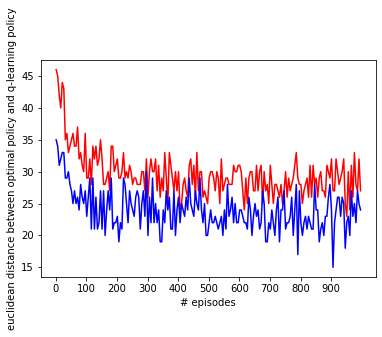

In [28]:
import matplotlib.pyplot as plt

plt.plot(eps, value_diff, 'r', eps, policy_diff, 'b')
plt.xlabel('# episodes')
plt.ylabel('euclidean distance between optimal policy and q-learning policy')
plt.xticks(np.arange(0, 1000, 100))
# lines.legend(['Value iteration', 'Policy iteration'])
plt.show()

In [26]:
### Difference between Q learning policy and optimal policies (for both algorithms) as a function of # episodes ###
# difference = number of states where action is not the same

# intervals of 5
eps = np.arange(1,1000,5) # np.arange includes the lower bound, excludes upper bound

value_diff = []
policy_diff = []

for e in range(len(eps)):
    temp_policy, Q, steps = q_learning(episodes=eps[e])  
    
    # need to do a conversion of temp_policy for Q-learning and value iteration policy to be a list like
    # policy iteration policy so that we can compare below
    temp_policy_convert = []
    policy_convert = []
    
    for i in range(temp_policy.shape[0]): # i.e. the rows of temp_policy = # states
        temp_policy_convert.append( temp_policy[i, :].tolist().index(1) )
        policy_convert.append( policy[i,:].tolist().index(1) )
    
    value_diff.append(np.count_nonzero( np.asarray(temp_policy_convert) - np.asarray(policy_convert) ))
    policy_diff.append(np.count_nonzero( np.asarray(temp_policy_convert) - np.asarray(policy2) ))

Episode # 0
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode

Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Epis

Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66

Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episo

Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episod

Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125

Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episod

Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92

Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episod

Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87

Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episod

Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
E

Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode 

Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episod

Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Epi

Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
E

Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episod

Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 16

Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Epis

Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Epis

Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode #

Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
E

Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episod

Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episod

Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24

Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episod

Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episod

Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode

Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episo

Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episod

Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 

Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episod

Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episo

Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episod

Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode #

Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episod

Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episod

Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episod

Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode

Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episod

Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episod

Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode 

Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episode # 175
Episode # 176
Episode # 177
Episode # 178
Episode # 179
Episode # 180
Episode # 181
Episode # 182
Episode # 183
Episode # 184
Episode # 185
Episode # 186
Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episod

Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episod

Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episod

Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 

Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episod

Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episod

Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episod

Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 

Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episod

Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episod

Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Ep

Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episod

Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episod

Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episod

Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episod

Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episod

Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episod

Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episod

Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Epis

Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episod

Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episod

Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episod

Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episod

Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episod

Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episod

Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episod

Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episod

Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episod

Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99

Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episode # 159
Episode # 160
Episode # 161
Episode # 162
Episode # 163
Episode # 164
Episode # 165
Episode # 166
Episode # 167
Episode # 168
Episode # 169
Episode # 170
Episode # 171
Episode # 172
Episode # 173
Episode # 174
Episod

Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Epis

Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episod

Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episod

Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episod

Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episod

Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episod

Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66

Episode # 590
Episode # 591
Episode # 592
Episode # 593
Episode # 594
Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episod

Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episode # 589
Episod

Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episod

Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episode # 258
Episode # 259
Episode # 260
Episode # 261
Episod

Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 6

Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episod

Episode # 595
Episode # 596
Episode # 597
Episode # 598
Episode # 599
Episode # 600
Episode # 601
Episode # 602
Episode # 603
Episode # 604
Episode # 605
Episode # 606
Episode # 607
Episode # 608
Episode # 609
Episode # 610
Episode # 611
Episode # 612
Episode # 613
Episode # 614
Episode # 615
Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episod

Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episod

Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode 

Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episod

Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episod

Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episod

Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episod

Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episod

Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episod

Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episod

Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episod

Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episod

Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episode # 805
Episode # 806
Episode # 807
Episode # 808
Episode # 809
Episode # 810
Episode # 811
Episode # 812
Episode # 813
Episode # 814
Episode # 815
Episode # 816
Episode # 817
Episode # 818
Episode # 819
Episode # 820
Episode # 821
Episode # 822
Episode # 823
Episode # 824
Episod

Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episod

Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episod

Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episod

Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
E

Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episod

Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episod

Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episod

Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episode # 330
Episode # 331
Episode # 332
Episode # 333
Episode # 334
Episode # 335
Episode # 336
Episode # 337
Episode # 338
Episode # 339
Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episod

Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episod

Episode # 875
Episode # 876
Episode # 877
Episode # 878
Episode # 879
Episode # 880
Episode # 881
Episode # 882
Episode # 883
Episode # 884
Episode # 885
Episode # 886
Episode # 887
Episode # 888
Episode # 889
Episode # 890
Episode # 891
Episode # 892
Episode # 893
Episode # 894
Episode # 895
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
E

Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episode # 802
Episode # 803
Episode # 804
Episod

Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episode # 795
Episode # 796
Episode # 797
Episode # 798
Episode # 799
Episode # 800
Episode # 801
Episod

Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episod

Episode # 340
Episode # 341
Episode # 342
Episode # 343
Episode # 344
Episode # 345
Episode # 346
Episode # 347
Episode # 348
Episode # 349
Episode # 350
Episode # 351
Episode # 352
Episode # 353
Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episod

Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98

Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episod

Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episod

Episode # 187
Episode # 188
Episode # 189
Episode # 190
Episode # 191
Episode # 192
Episode # 193
Episode # 194
Episode # 195
Episode # 196
Episode # 197
Episode # 198
Episode # 199
Episode # 200
Episode # 201
Episode # 202
Episode # 203
Episode # 204
Episode # 205
Episode # 206
Episode # 207
Episode # 208
Episode # 209
Episode # 210
Episode # 211
Episode # 212
Episode # 213
Episode # 214
Episode # 215
Episode # 216
Episode # 217
Episode # 218
Episode # 219
Episode # 220
Episode # 221
Episode # 222
Episode # 223
Episode # 224
Episode # 225
Episode # 226
Episode # 227
Episode # 228
Episode # 229
Episode # 230
Episode # 231
Episode # 232
Episode # 233
Episode # 234
Episode # 235
Episode # 236
Episode # 237
Episode # 238
Episode # 239
Episode # 240
Episode # 241
Episode # 242
Episode # 243
Episode # 244
Episode # 245
Episode # 246
Episode # 247
Episode # 248
Episode # 249
Episode # 250
Episode # 251
Episode # 252
Episode # 253
Episode # 254
Episode # 255
Episode # 256
Episode # 257
Episod

Episode # 835
Episode # 836
Episode # 837
Episode # 838
Episode # 839
Episode # 840
Episode # 841
Episode # 842
Episode # 843
Episode # 844
Episode # 845
Episode # 846
Episode # 847
Episode # 848
Episode # 849
Episode # 850
Episode # 851
Episode # 852
Episode # 853
Episode # 854
Episode # 855
Episode # 856
Episode # 857
Episode # 858
Episode # 859
Episode # 860
Episode # 861
Episode # 862
Episode # 863
Episode # 864
Episode # 865
Episode # 866
Episode # 867
Episode # 868
Episode # 869
Episode # 870
Episode # 871
Episode # 872
Episode # 873
Episode # 874
Episode # 875
Episode # 876
Episode # 877
Episode # 878
Episode # 879
Episode # 880
Episode # 881
Episode # 882
Episode # 883
Episode # 884
Episode # 885
Episode # 886
Episode # 887
Episode # 888
Episode # 889
Episode # 890
Episode # 891
Episode # 892
Episode # 893
Episode # 894
Episode # 895
Episode # 896
Episode # 897
Episode # 898
Episode # 899
Episode # 900
Episode # 901
Episode # 902
Episode # 903
Episode # 904
Episode # 905
Episod

Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episode # 742
Episode # 743
Episode # 744
Episode # 745
Episode # 746
Episode # 747
Episode # 748
Episode # 749
Episode # 750
Episode # 751
Episode # 752
Episode # 753
Episode # 754
Episode # 755
Episode # 756
Episode # 757
Episode # 758
Episode # 759
Episode # 760
Episode # 761
Episode # 762
Episode # 763
Episode # 764
Episode # 765
Episode # 766
Episode # 767
Episode # 768
Episode # 769
Episode # 770
Episode # 771
Episode # 772
Episode # 773
Episode # 774
Episode # 775
Episode # 776
Episode # 777
Episode # 778
Episode # 779
Episode # 780
Episode # 781
Episode # 782
Episode # 783
Episode # 784
Episode # 785
Episode # 786
Episode # 787
Episode # 788
Episode # 789
Episode # 790
Episode # 791
Episode # 792
Episode # 793
Episode # 794
Episod

Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episod

Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episode # 455
Episode # 456
Episode # 457
Episode # 458
Episode # 459
Episode # 460
Episode # 461
Episode # 462
Episode # 463
Episode # 464
Episode # 465
Episode # 466
Episode # 467
Episode # 468
Episode # 469
Episode # 470
Episode # 471
Episode # 472
Episode # 473
Episode # 474
Episode # 475
Episode # 476
Episode # 477
Episode # 478
Episode # 479
Episode # 480
Episode # 481
Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episod

Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 101
Episode # 102
Episode # 103
Episode # 104
Episode # 105
Episode # 106
Episode # 107
Episode # 108
Episode # 109
Episode # 110
Episode # 111
Episode # 112
Episode # 113
Episode # 114
Episode # 115
Episode # 116
Episode # 117
Episode # 118
Episode # 119
Episode # 120
Episode # 121
Episode # 122
Episode # 123
Episode # 124
Episode # 125
Episode # 126
Episode # 127
Episode # 128
Episode # 129
Episode # 130
Episode # 131
Episode # 132
Episode # 133
Episode # 134
Episode # 135
Episode # 136
Episode # 137
Episode # 138
Episode # 139
Episode # 140
Episode # 141
Episode # 142
Episode # 143
Episode # 144
Episode # 145
Episode # 146
Episode # 147
Episode # 148
Episode # 149
Episode # 150
Episode # 151
Episode # 152
Episode # 153
Episode # 154
Episode # 155
Episode # 156
Episode # 157
Episode # 158
Episo

Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode # 78
Episode # 79
Episode # 80
Episode # 81
Episode # 82
Episode # 83
Episode # 84
Episode # 85
Episode # 86
Episode # 87
Episode # 88
Episode # 89
Episode # 90
Episode # 91
Episode # 92
Episode # 93
Episode # 94
Episode # 95
Episode # 96
Episode # 97
Episode # 98
Episode # 99
Episode # 100
Episode # 1

Episode # 616
Episode # 617
Episode # 618
Episode # 619
Episode # 620
Episode # 621
Episode # 622
Episode # 623
Episode # 624
Episode # 625
Episode # 626
Episode # 627
Episode # 628
Episode # 629
Episode # 630
Episode # 631
Episode # 632
Episode # 633
Episode # 634
Episode # 635
Episode # 636
Episode # 637
Episode # 638
Episode # 639
Episode # 640
Episode # 641
Episode # 642
Episode # 643
Episode # 644
Episode # 645
Episode # 646
Episode # 647
Episode # 648
Episode # 649
Episode # 650
Episode # 651
Episode # 652
Episode # 653
Episode # 654
Episode # 655
Episode # 656
Episode # 657
Episode # 658
Episode # 659
Episode # 660
Episode # 661
Episode # 662
Episode # 663
Episode # 664
Episode # 665
Episode # 666
Episode # 667
Episode # 668
Episode # 669
Episode # 670
Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episod

Episode # 482
Episode # 483
Episode # 484
Episode # 485
Episode # 486
Episode # 487
Episode # 488
Episode # 489
Episode # 490
Episode # 491
Episode # 492
Episode # 493
Episode # 494
Episode # 495
Episode # 496
Episode # 497
Episode # 498
Episode # 499
Episode # 500
Episode # 501
Episode # 502
Episode # 503
Episode # 504
Episode # 505
Episode # 506
Episode # 507
Episode # 508
Episode # 509
Episode # 510
Episode # 511
Episode # 512
Episode # 513
Episode # 514
Episode # 515
Episode # 516
Episode # 517
Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episod

Episode # 354
Episode # 355
Episode # 356
Episode # 357
Episode # 358
Episode # 359
Episode # 360
Episode # 361
Episode # 362
Episode # 363
Episode # 364
Episode # 365
Episode # 366
Episode # 367
Episode # 368
Episode # 369
Episode # 370
Episode # 371
Episode # 372
Episode # 373
Episode # 374
Episode # 375
Episode # 376
Episode # 377
Episode # 378
Episode # 379
Episode # 380
Episode # 381
Episode # 382
Episode # 383
Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episod

Episode # 961
Episode # 962
Episode # 963
Episode # 964
Episode # 965
Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Epis

Episode # 887
Episode # 888
Episode # 889
Episode # 890
Episode # 891
Episode # 892
Episode # 893
Episode # 894
Episode # 895
Episode # 896
Episode # 897
Episode # 898
Episode # 899
Episode # 900
Episode # 901
Episode # 902
Episode # 903
Episode # 904
Episode # 905
Episode # 906
Episode # 907
Episode # 908
Episode # 909
Episode # 910
Episode # 911
Episode # 912
Episode # 913
Episode # 914
Episode # 915
Episode # 916
Episode # 917
Episode # 918
Episode # 919
Episode # 920
Episode # 921
Episode # 922
Episode # 923
Episode # 924
Episode # 925
Episode # 926
Episode # 927
Episode # 928
Episode # 929
Episode # 930
Episode # 931
Episode # 932
Episode # 933
Episode # 934
Episode # 935
Episode # 936
Episode # 937
Episode # 938
Episode # 939
Episode # 940
Episode # 941
Episode # 942
Episode # 943
Episode # 944
Episode # 945
Episode # 946
Episode # 947
Episode # 948
Episode # 949
Episode # 950
Episode # 951
Episode # 952
Episode # 953
Episode # 954
Episode # 955
Episode # 956
Episode # 957
Episod

Episode # 518
Episode # 519
Episode # 520
Episode # 521
Episode # 522
Episode # 523
Episode # 524
Episode # 525
Episode # 526
Episode # 527
Episode # 528
Episode # 529
Episode # 530
Episode # 531
Episode # 532
Episode # 533
Episode # 534
Episode # 535
Episode # 536
Episode # 537
Episode # 538
Episode # 539
Episode # 540
Episode # 541
Episode # 542
Episode # 543
Episode # 544
Episode # 545
Episode # 546
Episode # 547
Episode # 548
Episode # 549
Episode # 550
Episode # 551
Episode # 552
Episode # 553
Episode # 554
Episode # 555
Episode # 556
Episode # 557
Episode # 558
Episode # 559
Episode # 560
Episode # 561
Episode # 562
Episode # 563
Episode # 564
Episode # 565
Episode # 566
Episode # 567
Episode # 568
Episode # 569
Episode # 570
Episode # 571
Episode # 572
Episode # 573
Episode # 574
Episode # 575
Episode # 576
Episode # 577
Episode # 578
Episode # 579
Episode # 580
Episode # 581
Episode # 582
Episode # 583
Episode # 584
Episode # 585
Episode # 586
Episode # 587
Episode # 588
Episod

Episode # 384
Episode # 385
Episode # 386
Episode # 387
Episode # 388
Episode # 389
Episode # 390
Episode # 391
Episode # 392
Episode # 393
Episode # 394
Episode # 395
Episode # 396
Episode # 397
Episode # 398
Episode # 399
Episode # 400
Episode # 401
Episode # 402
Episode # 403
Episode # 404
Episode # 405
Episode # 406
Episode # 407
Episode # 408
Episode # 409
Episode # 410
Episode # 411
Episode # 412
Episode # 413
Episode # 414
Episode # 415
Episode # 416
Episode # 417
Episode # 418
Episode # 419
Episode # 420
Episode # 421
Episode # 422
Episode # 423
Episode # 424
Episode # 425
Episode # 426
Episode # 427
Episode # 428
Episode # 429
Episode # 430
Episode # 431
Episode # 432
Episode # 433
Episode # 434
Episode # 435
Episode # 436
Episode # 437
Episode # 438
Episode # 439
Episode # 440
Episode # 441
Episode # 442
Episode # 443
Episode # 444
Episode # 445
Episode # 446
Episode # 447
Episode # 448
Episode # 449
Episode # 450
Episode # 451
Episode # 452
Episode # 453
Episode # 454
Episod

Episode # 259
Episode # 260
Episode # 261
Episode # 262
Episode # 263
Episode # 264
Episode # 265
Episode # 266
Episode # 267
Episode # 268
Episode # 269
Episode # 270
Episode # 271
Episode # 272
Episode # 273
Episode # 274
Episode # 275
Episode # 276
Episode # 277
Episode # 278
Episode # 279
Episode # 280
Episode # 281
Episode # 282
Episode # 283
Episode # 284
Episode # 285
Episode # 286
Episode # 287
Episode # 288
Episode # 289
Episode # 290
Episode # 291
Episode # 292
Episode # 293
Episode # 294
Episode # 295
Episode # 296
Episode # 297
Episode # 298
Episode # 299
Episode # 300
Episode # 301
Episode # 302
Episode # 303
Episode # 304
Episode # 305
Episode # 306
Episode # 307
Episode # 308
Episode # 309
Episode # 310
Episode # 311
Episode # 312
Episode # 313
Episode # 314
Episode # 315
Episode # 316
Episode # 317
Episode # 318
Episode # 319
Episode # 320
Episode # 321
Episode # 322
Episode # 323
Episode # 324
Episode # 325
Episode # 326
Episode # 327
Episode # 328
Episode # 329
Episod

Episode # 0
Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode #

Episode # 883
Episode # 884
Episode # 885
Episode # 886
Episode # 887
Episode # 888
Episode # 889
Episode # 890
Episode # 891
Episode # 892
Episode # 893
Episode # 894
Episode # 895
Episode # 896
Episode # 897
Episode # 898
Episode # 899
Episode # 900
Episode # 901
Episode # 902
Episode # 903
Episode # 904
Episode # 905
Episode # 906
Episode # 907
Episode # 908
Episode # 909
Episode # 910
Episode # 911
Episode # 912
Episode # 913
Episode # 914
Episode # 915
Episode # 916
Episode # 917
Episode # 918
Episode # 919
Episode # 920
Episode # 921
Episode # 922
Episode # 923
Episode # 924
Episode # 925
Episode # 926
Episode # 927
Episode # 928
Episode # 929
Episode # 930
Episode # 931
Episode # 932
Episode # 933
Episode # 934
Episode # 935
Episode # 936
Episode # 937
Episode # 938
Episode # 939
Episode # 940
Episode # 941
Episode # 942
Episode # 943
Episode # 944
Episode # 945
Episode # 946
Episode # 947
Episode # 948
Episode # 949
Episode # 950
Episode # 951
Episode # 952
Episode # 953
Episod

Episode # 671
Episode # 672
Episode # 673
Episode # 674
Episode # 675
Episode # 676
Episode # 677
Episode # 678
Episode # 679
Episode # 680
Episode # 681
Episode # 682
Episode # 683
Episode # 684
Episode # 685
Episode # 686
Episode # 687
Episode # 688
Episode # 689
Episode # 690
Episode # 691
Episode # 692
Episode # 693
Episode # 694
Episode # 695
Episode # 696
Episode # 697
Episode # 698
Episode # 699
Episode # 700
Episode # 701
Episode # 702
Episode # 703
Episode # 704
Episode # 705
Episode # 706
Episode # 707
Episode # 708
Episode # 709
Episode # 710
Episode # 711
Episode # 712
Episode # 713
Episode # 714
Episode # 715
Episode # 716
Episode # 717
Episode # 718
Episode # 719
Episode # 720
Episode # 721
Episode # 722
Episode # 723
Episode # 724
Episode # 725
Episode # 726
Episode # 727
Episode # 728
Episode # 729
Episode # 730
Episode # 731
Episode # 732
Episode # 733
Episode # 734
Episode # 735
Episode # 736
Episode # 737
Episode # 738
Episode # 739
Episode # 740
Episode # 741
Episod

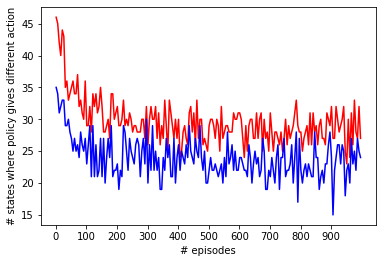

In [29]:
import matplotlib.pyplot as plt

plt.plot(eps, value_diff, 'r', eps, policy_diff, 'b')
plt.xlabel('# episodes')
plt.ylabel('# states where policy gives different action')
plt.xticks(np.arange(0, 1000, 100))
# lines.legend(['Value iteration', 'Policy iteration'])
plt.show()